# PURSUE Scikit-HEP Session Lecture Notebook (Part 2)

## Introduction
- In this notebook we will have a look at other useful libraries offered by Scikit-HEP, as well as taking a dive into more advanced topics beyond I/O with root files, slicing, filtering, and plotting data.

## Combinatronics
- Suppose you are are searching for a particular signal: two muons with opposite charge. There's one issue though: there might be events with any number of positive and negative muons. How do you know that any combination of them correspond to the final state of the particular signal you are looking for. This is not immediately known!
- A power technique which is enabled by the tools offered in Scikit-HEP is to use combinatronics: consider every possible combination of oppositely charged muons and select those which meet some other selection criteria consistent with your signal of interest!
- Let's see what combinatronics is about. Suppose you have the following two arrays.

In [1]:
import awkward as ak

In [2]:
numbers = ak.Array([[1, 2, 3], [], [5, 7], [11]])
letters = ak.Array([["a", "b"], ["c"], ["d"], ["e", "f"]])

- The function `ak.cartesian` gives us the cartesian product of two arrays. If we use it to take the cartesian product of `numbers` and `letters`, we are given an array of the cartesian product of each of the sub-arrays of one of the arrays with the corresponding sub-array in the other.

In [3]:
pairs = ak.cartesian((numbers, letters))
pairs

<Array [[(1, 'a'), (...), ..., (3, 'b')], ...] type='4 * var * (int64, string)'>

- We can access the objects inside this Awkard array multiple ways. For example, we can slice using strings

In [4]:
pairs["0"]

<Array [[1, 1, 2, 2, 3, 3], [], [5, ...], [11, 11]] type='4 * var * int64'>

In [5]:
pairs["1"]

<Array [['a', 'b', 'a', 'b', 'a', 'b'], [], ..., [...]] type='4 * var * string'>

- But we can also use the function `ak.unzip` to extract every field into its own separate array.

In [6]:
left, right = ak.unzip(pairs)
print(left)
print(right)

[[1, 1, 2, 2, 3, 3], [], [5, 7], [11, 11]]
[['a', 'b', 'a', 'b', 'a', 'b'], [], ['d', 'd'], ['e', 'f']]


- In addition to `ak.cartesian`, another combinatorial function Awkward provides is `ak.combinations`. This function allows us to find all pairs withing a single collection, without repetition. For instance.

In [7]:
# As a reminder
print(numbers)

[[1, 2, 3], [], [5, 7], [11]]


In [8]:
# The number of items to choose in each list: 2 chooses unique pairs, 3 chooses unique triples, etc.
comb_size = 2

pairs = ak.combinations(numbers, comb_size)
pairs

<Array [[(1, 2), (1, ...), (2, 3)], ..., []] type='4 * var * (int64, int64)'>

- With every possible pair of elements, we can unzip this array similar to how we did the previous one we had.

In [9]:
left, right = ak.unzip(pairs)
print(left)
print(right)

[[1, 1, 2], [], [5], []]
[[2, 3, 3], [], [7], []]


- Notice that they line up. We can therefore perform operations between these two arrays as such.

In [10]:
left * right

<Array [[2, 3, 6], [], [35], []] type='4 * var * int64'>

## Dimuons Revisited
- In the last notebook, we were working with dimuon data and were able to effetively plot the dimuon mass spectrum. However, in the process, we made a pretty unreasonable cut: we only considered events which had two muons. This means we were not taking into account data which might be relevant for our search!
- Now, we are going to perform the same mini-analysis, but we are going to take a more nuanced approach using combinatronics. First we load in the data.

In [76]:
import uproot
import awkward as ak
import vector

file = uproot.open(
    # "root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root"
    "uproot-tutorial-file.root"
)
tree = file["Events"]

arrays = tree.arrays(filter_name="/Muon_(pt|eta|phi|charge)/", entry_stop=10000)

muons = ak.zip(
    {
        "pt": arrays["Muon_pt"],
        "eta": arrays["Muon_eta"],
        "phi": arrays["Muon_phi"],
        "charge": arrays["Muon_charge"],
    }
)

arrays.type

ArrayType(RecordType([ListType(NumpyType('float32')), ListType(NumpyType('float32')), ListType(NumpyType('float32')), ListType(NumpyType('int32'))], ['Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_charge']), 10000, None)

- Lets get all possible combinations of 2 muons for each event and then separate each into a separate array that we can add in order to get the mass.

In [78]:
pairs = ak.combinations(muons, 2)
mu1, mu2 = ak.unzip(pairs)

- With `ak.unzip` we can get the first and second muon in each pair separately and then use those separate arrays to compute the invariant mass of each pair.
$$
    m = \sqrt{
        2p_{T1}p_{T2}\cosh(\eta_1 - \eta_2) - \cos(\phi_1 - \phi_2)
    }
$$

In [79]:
import numpy as np

mu1, mu2 = ak.unzip(pairs)

mass = np.sqrt(
    2 * mu1.pt * mu2.pt * (np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))
)

- We will now use a histograming tool provided to us by Scikit-HEP: Hist. How is using Hist better than just using vanilla Matplotlib.
  1. You can more easily get advanced binning options such as variable and irregular bins, and multiple axis types
  2. Built on top of `boost-histogram` library which offers powerful histogram operations with high performance.
  3. Offers methods beyond plotting histograms such as histogram manipulations and the calculation of statistical properties directly from the histogram objects.
- Lets go ahead and use it!

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x146152810>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

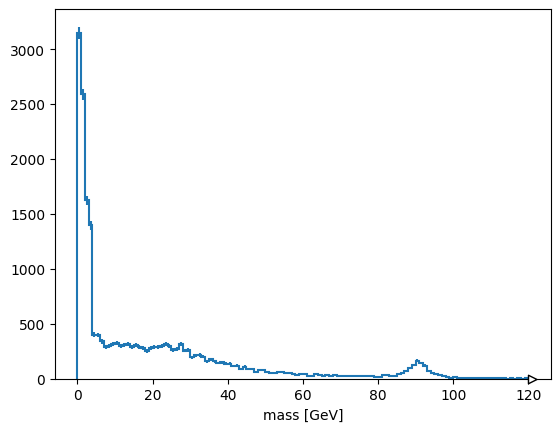

In [81]:
import hist
import matplotlib.pyplot as plt

h = hist.Hist(hist.axis.Regular(120, 0, 120, name="mass", label="mass [GeV]"))
h.fill(ak.ravel(mass))
h.plot()

- Plotting this in a way that will seem more familiar... 

/var/folders/t8/8pnmh4rj2lbbd7gfq8tf09180000gn/T/ipykernel_41673/3770819677.py:12: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 10e3)


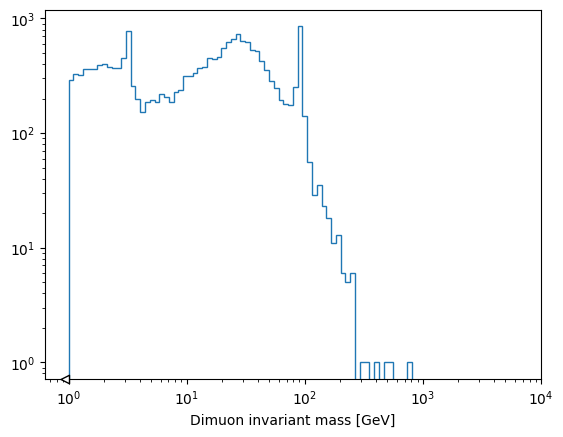

In [158]:
hlog = hist.Hist(
    hist.axis.Variable(
        np.logspace(np.log10(10e-1), np.log10(10e3), 100),
        ), 
    )
hlog.fill(ak.ravel(mass))

fig, ax = plt.subplots()
hlog.plot(ax=ax, yerr=False, lw=1)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0, 10e3)
ax.set_xlabel("Dimuon invariant mass [GeV]")
plt.show()

- We can see that we can already see the Z peak, but $J/\psi$ peaks, but not much else.
- For now, however, lets focus on Z0, which we can see in the plot which is not logarithmic as a peak at ~90 GeV. To improve the plot, we can impose charge conservation as shown here

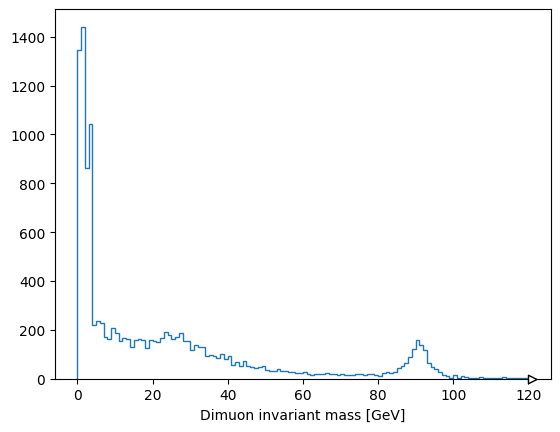

In [198]:
oppq_mask = mu1["charge"] != mu2["charge"]
mass_oppq = mass[oppq_mask]

h_oppq = hist.Hist(
    hist.axis.Regular(
        120, 0, 120
        ), 
    )
h_oppq.fill(ak.ravel(mass_oppq))

fig, ax = plt.subplots()
h_oppq.plot(ax=ax, yerr=False, lw=1)
ax.set_xlabel("Dimuon invariant mass [GeV]")
plt.show()

In [199]:
import particle, hepunits

zmass = particle.Particle.findall("Z0")[0].mass / hepunits.GeV
zmass

91.1876

In [203]:
deltamass = abs(mass_oppq - zmass)
which = ak.argmin(deltamass, axis=1, keepdims=True)
nass_opq[which]

<Array [[None], [0], [None], ..., [0], [0], [0]] type='10000 * 1 * ?int64'>

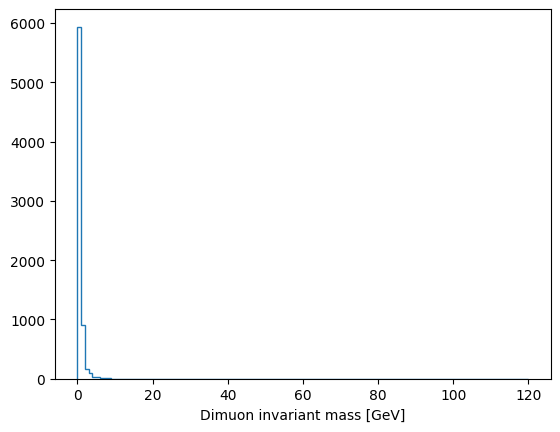

In [202]:
hlog_nearZ0mass = hist.Hist(
    hist.axis.Regular(
        120, 0, 120
        ), 
    )
hlog_nearZ0mass.fill(ak.ravel(nearZ0mass))

fig, ax = plt.subplots()
hlog_nearZ0mass.plot(ax=ax, yerr=False, lw=1)
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel("Dimuon invariant mass [GeV]")
plt.show()

- On the other hand, suppose we want to only plot in our histogram only the largest mass in each event. In this case we can use `ak.max`. Note, however, that some events will have no muons at all, so, for that event, the maximum element would be... `None`. To get rid of that, we can use the `ak.flatten` function along axis 0 which will automatically remove any such missing values.

In [30]:
max_mass = ak.flatten(ak.max(mass, axis=1), axis=0)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x2825353d0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

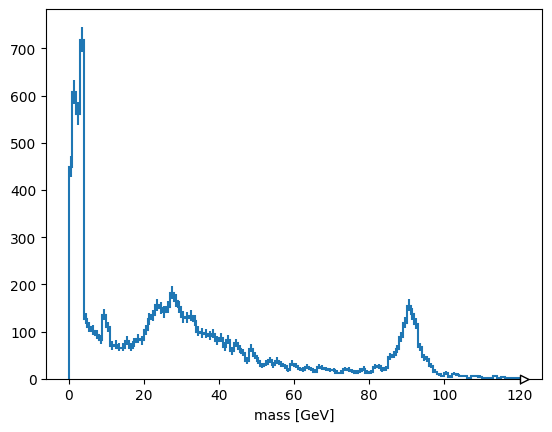

In [31]:
import hist
import matplotlib.pyplot as plt

h = hist.Hist(hist.axis.Regular(120, 0, 120, name="mass", label="mass [GeV]"))
h.fill(max_mass)
h.plot()

- We know that we want events which have muons of opposite charge.

In [ ]:
pairs_oppq = pairs[pairs["0"]["charge"] + pairs["1"]["charge"] == 0]

<Record ({rho: 10.5, ...}, {...}) type='(Momentum3D[rho: float32, phi: floa...'>

- In order to compute the mass, because we are working with four vectors, we can just add.

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x17fdd2c90>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

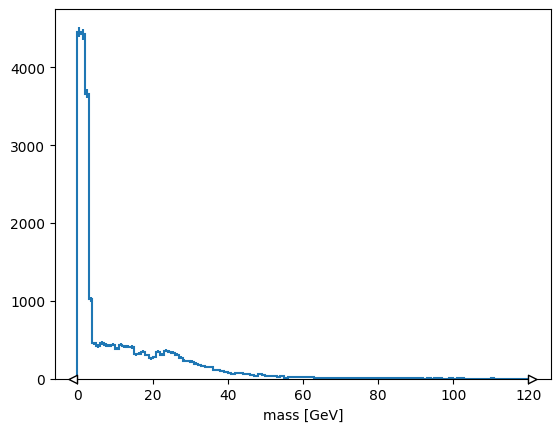

In [ ]:
import hist

hist.Hist(hist.axis.Regular(120, 0, 120, label="mass [GeV]")).fill(
    ak.ravel(pairs_oppq["0"] + pairs_oppq["1"])
).plot()
    

<Array [[False], [True], [], ..., [True], [True]] type='10000 * var * bool'>